In [1]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine, text, MetaData
from sqlalchemy.exc import IntegrityError
import numpy as np

In [2]:
engine = create_engine('postgresql:///piwheels')
conn = engine.connect()
meta = MetaData()
meta.bind = conn
meta.reflect(views=True)

In [3]:
start_date = '2021-07-01'
start_time = '2021-07-01 00:00:00'
end_date = '2021-09-30'
end_time = '2021-10-01 00:00:00'
one_year_ago = '2020-10-01'

In [4]:
pd.read_sql(f"""
    SELECT COUNT(*) AS downloads_in_period
    FROM downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,downloads_in_period
0,7047854


In [5]:
pd.read_sql(f"""
    SELECT COUNT(*) AS downloads_to_date
    FROM downloads
    WHERE accessed_at::date < '{end_date}'
""", conn)

,downloads_to_date
0,55661834


In [6]:
pd.read_sql(f"""
    SELECT COUNT(*) AS project_page_hits
    FROM project_page_hits
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,project_page_hits
0,875834


In [7]:
pd.read_sql(f"""
    SELECT COUNT(*) AS project_json_downloads
    FROM project_json_downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,project_json_downloads
0,1094432


In [8]:
pd.read_sql(f"""
    SELECT COUNT(*) AS web_page_hits
    FROM web_page_hits
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,web_page_hits
0,397834


In [9]:
downloads_by_month = pd.read_sql(f"""
    SELECT date_trunc('month', accessed_at) m, COUNT(*) AS c
    FROM downloads
    WHERE accessed_at::date BETWEEN '{one_year_ago}' AND '{end_date}'
    GROUP BY m
    ORDER BY m
""", conn)

downloads_by_month

,m,c
0,2020-10-01,1850781
1,2020-11-01,1240661
2,2020-12-01,1552508
3,2021-01-01,1960137
4,2021-02-01,3424032
5,2021-03-01,3878585
6,2021-04-01,2956219
7,2021-05-01,2752983
8,2021-06-01,2762739
9,2021-07-01,2325759


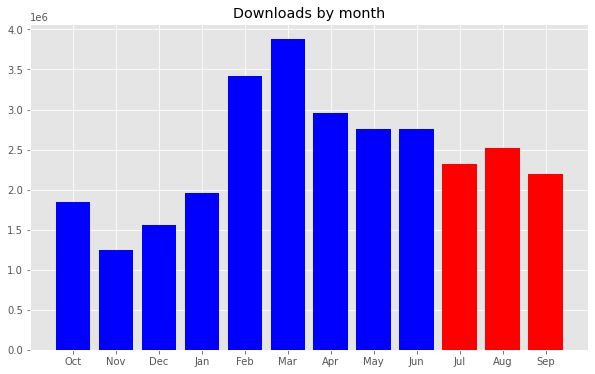

In [60]:
plt.rcParams["figure.figsize"] = (10, 6)

months = [m.month_name()[:3] for m in downloads_by_month['m']]
downloads = [c for c in downloads_by_month['c']]

colors = ['blue']*9 + ['red']*3
plt.bar(range(12), downloads, color=colors)
plt.title('Downloads by month')
plt.xticks(range(12), months)

plt.savefig('downloads-by-month.png')

plt.show()

In [11]:
downloads_by_day = pd.read_sql(f"""
    SELECT accessed_at::date AS d, COUNT(*) AS downloads
    FROM downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY d
    ORDER BY d
""", conn)

downloads_by_day

,d,downloads
0,2021-07-01,112953
1,2021-07-02,90084
2,2021-07-03,68950
3,2021-07-04,73506
4,2021-07-05,89507
...,...,...
87,2021-09-26,59820
88,2021-09-27,82292
89,2021-09-28,76716
90,2021-09-29,81520


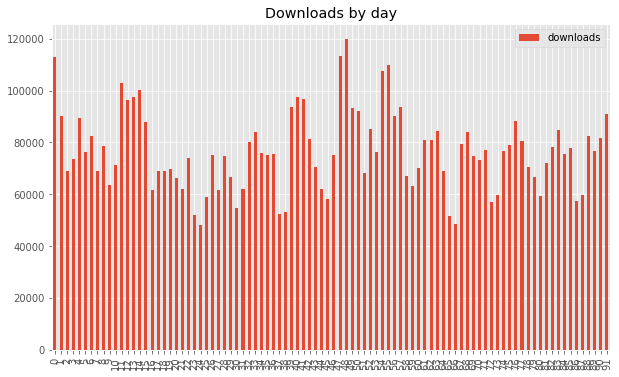

In [61]:
p = downloads_by_day.plot.bar(title='Downloads by day')
p.figure.savefig('downloads-by-day.png')

In [13]:
df = pd.read_sql(f"""
    SELECT COUNT(*) AS searches_in_period
    FROM searches
    WHERE accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
""", conn)

searches = df.values[0][0]
searches

48256952

In [14]:
pd.read_sql(f"""
    SELECT date_trunc('month', accessed_at) AS month, COUNT(*) AS searches
    FROM searches
    WHERE accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    GROUP BY month
    ORDER BY month
""", conn)

,month,searches
0,2021-07-01,19092849
1,2021-08-01,17141762
2,2021-09-01,12022341


In [15]:
searches_by_day = pd.read_sql(f"""
    SELECT accessed_at::date AS day, COUNT(*) AS searches
    FROM searches
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY day
    ORDER BY day
""", conn)

searches_by_day

,day,searches
0,2021-07-01,663189
1,2021-07-02,573578
2,2021-07-03,520430
3,2021-07-04,516349
4,2021-07-05,616019
...,...,...
87,2021-09-26,322228
88,2021-09-27,420188
89,2021-09-28,399966
90,2021-09-29,410543


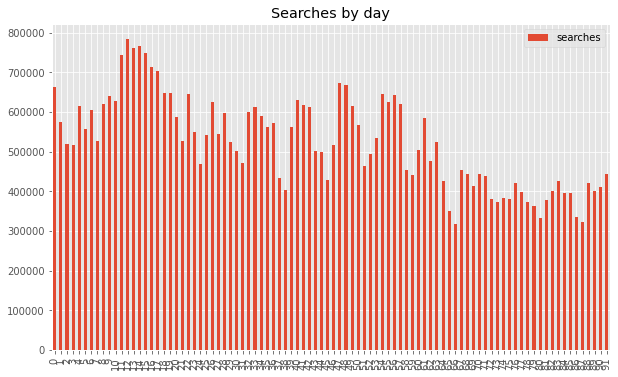

In [62]:
p = searches_by_day.plot.bar(title='Searches by day')
p.figure.savefig('searches-by-day.png')

In [17]:
pd.read_sql(f"""
    SELECT JUSTIFY_INTERVAL(SUM(
        CASE f.platform_tag
            WHEN 'linux_armv7l' THEN 1                           
            WHEN 'linux_armv6l' THEN 6                                                       
            ELSE 0           
        END *
        CASE                        
            WHEN b.duration > INTERVAL '1 day' THEN INTERVAL '0'
            WHEN b.duration > INTERVAL '6.7 seconds' THEN b.duration - INTERVAL '6.7 seconds'
            ELSE INTERVAL '0'               
        END                  
        )) AS total_time_saved_in_quarter                        
    FROM downloads d
    JOIN files f ON d.filename = f.filename
    JOIN builds b ON b.build_id = f.build_id
    WHERE f.abi_tag <> 'none'
    AND d.accessed_at::date between '{start_date}' and '{end_date}'
""", conn)

,total_time_saved_in_quarter
0,12048 days 00:50:30.453081


In [18]:
time_saved_by_month = pd.read_sql(f"""
    SELECT date_trunc('month', d.accessed_at) as month, JUSTIFY_INTERVAL(SUM(
        CASE f.platform_tag
            WHEN 'linux_armv7l' THEN 1
            WHEN 'linux_armv6l' THEN 6
            ELSE 0
        END *
        CASE
            WHEN b.duration > INTERVAL '1 day' THEN INTERVAL '0'
            WHEN b.duration > INTERVAL '6.7 seconds' THEN b.duration - INTERVAL '6.7 seconds'
            ELSE INTERVAL '0'
        END
            )) AS time_saved_in_month
    FROM downloads d
    JOIN files f ON d.filename = f.filename
    JOIN builds b ON b.build_id = f.build_id
    WHERE f.abi_tag <> 'none'
    AND d.accessed_at::date between '{one_year_ago}' and '{end_date}'
    GROUP BY month
    ORDER BY month
""", conn)

time_saved_by_month

,month,time_saved_in_month
0,2020-10-01,8074 days 17:26:14.875176
1,2020-11-01,6374 days 06:58:39.848346
2,2020-12-01,3878 days 06:59:28.147684
3,2021-01-01,3727 days 17:44:07.111225
4,2021-02-01,5639 days 08:25:11.612328
5,2021-03-01,6756 days 17:05:34.494183
6,2021-04-01,5148 days 08:09:03.090226
7,2021-05-01,4542 days 20:14:38.898707
8,2021-06-01,4240 days 19:47:36.009394
9,2021-07-01,3731 days 01:39:11.882878


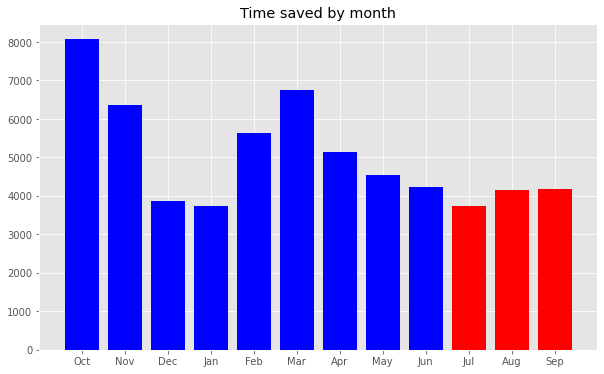

In [63]:
months = [m.month_name()[:3] for m in time_saved_by_month['month']]
days_saved = [ts.days for ts in time_saved_by_month['time_saved_in_month']]

colors = ['blue']*9 + ['red']*3
plt.bar(range(12), days_saved, color=colors)
plt.title('Time saved by month')
plt.xticks(range(12), months)

plt.savefig('time-saved-by-month.png')

plt.show()

In [20]:
top_10_downloads = pd.read_sql(f"""
    select b.package, count(*) c
    from downloads d
    join files f on f.filename = d.filename
    join builds b on b.build_id = f.build_id
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by b.package
    order by c desc
    limit 10;
""", conn)

top_10_downloads

,package,c
0,requests,116496
1,six,102660
2,numpy,100423
3,pip,98708
4,idna,94551
5,importlib-metadata,93747
6,urllib3,91259
7,certifi,87703
8,typing-extensions,85543
9,pillow,83796


In [21]:
print("<ol>")
for i, row in top_10_downloads.iterrows():
    print(f"<li><strong><a href='https://www.piwheels.org/project/{row['package']}'>{row['package']}</a></strong> ({row['c']:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/requests'>requests</a></strong> (116,496)</li>
<li><strong><a href='https://www.piwheels.org/project/six'>six</a></strong> (102,660)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (100,423)</li>
<li><strong><a href='https://www.piwheels.org/project/pip'>pip</a></strong> (98,708)</li>
<li><strong><a href='https://www.piwheels.org/project/idna'>idna</a></strong> (94,551)</li>
<li><strong><a href='https://www.piwheels.org/project/importlib-metadata'>importlib-metadata</a></strong> (93,747)</li>
<li><strong><a href='https://www.piwheels.org/project/urllib3'>urllib3</a></strong> (91,259)</li>
<li><strong><a href='https://www.piwheels.org/project/certifi'>certifi</a></strong> (87,703)</li>
<li><strong><a href='https://www.piwheels.org/project/typing-extensions'>typing-extensions</a></strong> (85,543)</li>
<li><strong><a href='https://www.piwheels.org/project/pillow'>pillow</a></strong> (83,796)</

In [22]:
top_10_searches = pd.read_sql(f"""
    select package, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    group by package
    order by c desc
    limit 10;
""", conn)

top_10_searches

,package,c
0,pip,7423597
1,wheel,4427701
2,setuptools,3375412
3,pyrogram,1762252
4,future,742655
5,youtube-dl,664821
6,pyngrok,645709
7,speedtest-cli,399889
8,six,379356
9,requests,377486


In [23]:
print("<ol>")
for pkg, c in top_10_searches.values:
    print(f"<li><strong><a href='https://www.piwheels.org/project/{pkg}'>{pkg}</a></strong> ({c:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/pip'>pip</a></strong> (7,423,597)</li>
<li><strong><a href='https://www.piwheels.org/project/wheel'>wheel</a></strong> (4,427,701)</li>
<li><strong><a href='https://www.piwheels.org/project/setuptools'>setuptools</a></strong> (3,375,412)</li>
<li><strong><a href='https://www.piwheels.org/project/pyrogram'>pyrogram</a></strong> (1,762,252)</li>
<li><strong><a href='https://www.piwheels.org/project/future'>future</a></strong> (742,655)</li>
<li><strong><a href='https://www.piwheels.org/project/youtube-dl'>youtube-dl</a></strong> (664,821)</li>
<li><strong><a href='https://www.piwheels.org/project/pyngrok'>pyngrok</a></strong> (645,709)</li>
<li><strong><a href='https://www.piwheels.org/project/speedtest-cli'>speedtest-cli</a></strong> (399,889)</li>
<li><strong><a href='https://www.piwheels.org/project/six'>six</a></strong> (379,356)</li>
<li><strong><a href='https://www.piwheels.org/project/requests'>requests</a></strong> (377,4

In [24]:
top_10_project_pages = pd.read_sql(f"""
    select package, count(*) c
    from project_page_hits
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by package
    order by c desc
    limit 10;
""", conn)

top_10_project_pages

,package,c
0,lilurl,2401
1,numpy,1354
2,opencv-python,1102
3,opencv-contrib-python,1044
4,scipy,1006
5,scikit-image,653
6,tensorflow,559
7,imagecodecs,523
8,cryptography,474
9,pandas,437


In [25]:
print("<ol>")
for pkg, c in top_10_project_pages.values:
    print(f"<li><strong><a href='https://www.piwheels.org/project/{pkg}'>{pkg}</a></strong> ({c:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/lilurl'>lilurl</a></strong> (2,401)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (1,354)</li>
<li><strong><a href='https://www.piwheels.org/project/opencv-python'>opencv-python</a></strong> (1,102)</li>
<li><strong><a href='https://www.piwheels.org/project/opencv-contrib-python'>opencv-contrib-python</a></strong> (1,044)</li>
<li><strong><a href='https://www.piwheels.org/project/scipy'>scipy</a></strong> (1,006)</li>
<li><strong><a href='https://www.piwheels.org/project/scikit-image'>scikit-image</a></strong> (653)</li>
<li><strong><a href='https://www.piwheels.org/project/tensorflow'>tensorflow</a></strong> (559)</li>
<li><strong><a href='https://www.piwheels.org/project/imagecodecs'>imagecodecs</a></strong> (523)</li>
<li><strong><a href='https://www.piwheels.org/project/cryptography'>cryptography</a></strong> (474)</li>
<li><strong><a href='https://www.piwheels.org/project/pandas'>pand

In [26]:
top_10_project_json = pd.read_sql(f"""
    select package, count(*) c
    from project_json_downloads
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by package
    order by c desc
    limit 10;
""", conn)

top_10_project_json

,package,c
0,awscrt,20679
1,numpy,458
2,opencv-contrib-python,107
3,v2ray-runtime-windows,104
4,requests-toolkit,103
5,github-http-api,96
6,bevy-events,95
7,newrelic-plugins-agent,95
8,v2ray-runtime,92
9,protobuf,91


In [27]:
print("<ol>")
for pkg, c in top_10_project_json.values:
    print(f"<li><strong><a href='https://www.piwheels.org/project/{pkg}'>{pkg}</a></strong> ({c:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/awscrt'>awscrt</a></strong> (20,679)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (458)</li>
<li><strong><a href='https://www.piwheels.org/project/opencv-contrib-python'>opencv-contrib-python</a></strong> (107)</li>
<li><strong><a href='https://www.piwheels.org/project/v2ray-runtime-windows'>v2ray-runtime-windows</a></strong> (104)</li>
<li><strong><a href='https://www.piwheels.org/project/requests-toolkit'>requests-toolkit</a></strong> (103)</li>
<li><strong><a href='https://www.piwheels.org/project/github-http-api'>github-http-api</a></strong> (96)</li>
<li><strong><a href='https://www.piwheels.org/project/bevy-events'>bevy-events</a></strong> (95)</li>
<li><strong><a href='https://www.piwheels.org/project/newrelic-plugins-agent'>newrelic-plugins-agent</a></strong> (95)</li>
<li><strong><a href='https://www.piwheels.org/project/v2ray-runtime'>v2ray-runtime</a></strong> (92)</li>
<li><st

In [28]:
pd.read_sql(f"""
    select count(distinct(package)) c
    from project_json_downloads
    where accessed_at::date between '{start_date}' and '{end_date}'
""", conn)

,c
0,320273


In [29]:
pd.read_sql(f"""
    select user_agent, count(*) c
    from project_json_downloads
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by user_agent
    order by c desc
""", conn)

,user_agent,c
0,python-requests,859378
1,mozilla,212817
2,python-urllib,21131
3,ccbot,982
4,clark-crawler2,55
5,node-fetch,25
6,tinybottestua,14
7,java,7
8,ahc,3
9,default,3


In [30]:
os_usage = pd.read_sql(f"""
    select os_name, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    group by os_name
    order by c desc
""", conn)

os_usage

,os_name,c
0,Linux,48221974
1,Windows,12494
2,FreeBSD,12372
3,Darwin,9978
4,Open Surface RT - Linux,112
5,CYGWIN_NT-10.0-18363,17
6,CYGWIN_NT-10.0-19042,4
7,None,1


In [31]:
linux_usage_pc = 100 * (os_usage.values[0][1] / searches)
print(f'{linux_usage_pc:2.2f}% linux')

99.93% linux


In [32]:
distro_usage = pd.read_sql(f"""
    select distro_name, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    group by distro_name
    order by c desc
    limit 5
""", conn)

distro_usage

,distro_name,c
0,Raspbian GNU/Linux,42562444
1,Debian GNU/Linux,5240197
2,Ubuntu,305544
3,OSMC,28180
4,CentOS Linux,26462


In [33]:
debian_usage = pd.read_sql(f"""
    select count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    order by c desc
    limit 5
""", conn)

debian_usage

,c
0,47802641


In [34]:
debian_usage_pc = 100 * (debian_usage.c[0] / searches)
print(f'{debian_usage_pc:2.2f}% debian')

99.06% debian


In [35]:
ubuntu_usage = pd.read_sql(f"""
    select count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    and distro_name = 'Ubuntu'
    order by c desc
    limit 5
""", conn)

ubuntu_usage_pc = 100 * (ubuntu_usage.c[0] / searches)
print(f'{ubuntu_usage_pc:2.2f}% ubuntu')

0.63% ubuntu


In [74]:
debian = debian_usage.values[0][0]
others = searches - debian

distro_usage = {
    'Debian / Raspberry Pi OS': debian,
    'Others': others,
}

distro_usage

{'Debian / Raspberry Pi OS': 47802641, 'Others': 454311}

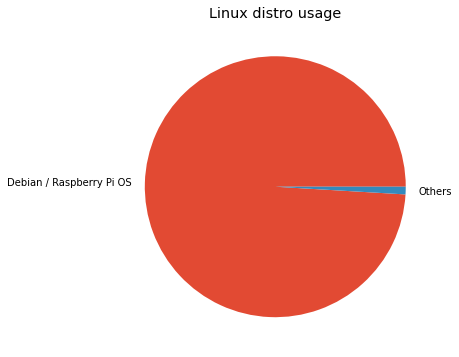

In [75]:
plt.pie(distro_usage.values(), labels=distro_usage.keys())
plt.title('Linux distro usage')

plt.savefig('distro-usage.png')

plt.show()

In [38]:
distro_versions = pd.read_sql(f"""
    select distro_version, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    and distro_version in ('8', '9', '10')
    group by distro_version
    order by c desc
""", conn)

distro_versions

,distro_version,c
0,10,43096039
1,9,3055783
2,8,447


In [39]:
total = sum(distro_versions.c)

for v in distro_versions.values:
    print(v[0], f'{(100 * v[1] / total):.1f}%')

10 93.4%
9 6.6%
8 0.0%


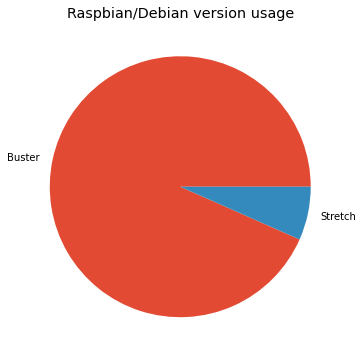

In [76]:
version_names = {'10': 'Buster', '9': 'Stretch', '8': 'Jessie'}
plt.pie(distro_versions.c[:2], labels=[version_names[v] for v in distro_versions.distro_version][:2])
plt.title('Raspbian/Debian version usage')

plt.savefig('debian-usage.png')

plt.show()

In [41]:
arch = pd.read_sql(f"""
    select arch, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    group by arch
    order by c desc
""", conn)

arch

,arch,c
0,armv7l,34280447
1,aarch64,9220922
2,x86_64,3025941
3,armv6l,1646874
4,i686,33443
5,armv8l,21254
6,AMD64,12494
7,amd64,12372
8,arm64,2699
9,ppc64,317


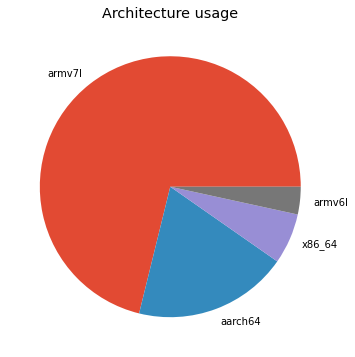

In [67]:
plt.pie(arch.c[:4], labels=arch.arch[:4])
plt.title('Architecture usage')

plt.savefig('arch.png')

plt.show()

In [43]:
arm_arch = pd.read_sql(f"""
    select arch, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    and arch in ('armv6l', 'armv7l', 'aarch64')
    group by arch
    order by c desc
""", conn)

total = sum(arm_arch.c)

for v in arm_arch.values:
    print(v[0], f'{(100 * v[1] / total):.1f}%') 

armv7l 76.0%
aarch64 20.3%
armv6l 3.6%


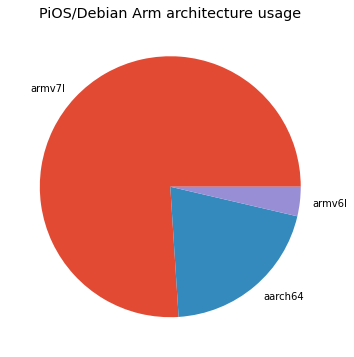

In [68]:
plt.pie(arm_arch.c, labels=arm_arch.arch)
plt.title('PiOS/Debian Arm architecture usage')

plt.savefig('debian-arch.png')

plt.show()

In [45]:
py_vers = pd.read_sql(f"""
    select substring(py_version from 1 for 3) pyver, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    and arch in ('armv6l', 'armv7l', 'aarch64')
    and py_name = 'CPython'
    group by pyver
    order by c desc
    limit 6
""", conn)

py_vers

,pyver,c
0,3.7,31147542
1,2.7,5243826
2,3.8,4595643
3,3.9,2154373
4,3.5,1656419
5,3.6,195502


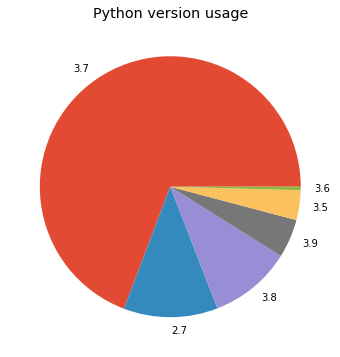

In [69]:
plt.pie(py_vers.c, labels=py_vers.pyver)
plt.title('Python version usage')

plt.savefig('py-vers.png')

plt.show()

In [47]:
total = sum(row[1] for row in py_vers.values)

for ver, c in py_vers.values:
    print(ver, f'{100 * (c / total):.2f}%')

3.7 69.23%
2.7 11.65%
3.8 10.21%
3.9 4.79%
3.5 3.68%
3.6 0.43%


In [48]:
pip_versions = pd.read_sql(f"""
    select installer_version, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and installer_name = 'pip'
    and installer_version is not null
    group by installer_version
    order by c desc
""", conn)

pip_versions[:10]

,installer_version,c
0,18.1,11070109
1,21.2.4,9608094
2,21.1.3,8857941
3,21.1.2,3928579
4,21.2.3,1806022
5,21.2.1,1765630
6,21.2.2,1726675
7,9.0.1,1484950
8,19.0.1,1384180
9,20.3.4,1166210


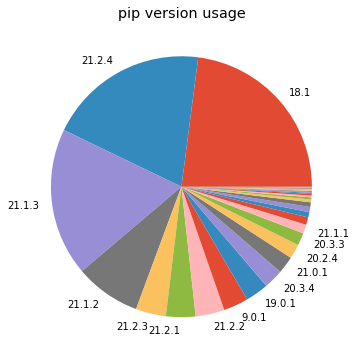

In [70]:
total = sum(v[1] for v in pip_versions.values)
labels = [v[0] if v[1] / total > 0.01 else '' for v in pip_versions.values]

plt.pie(pip_versions.c, labels=labels)
plt.title('pip version usage')

plt.savefig('pip-vers.png')

plt.show()

In [50]:
setuptools_versions = pd.read_sql(f"""
    select setuptools_version, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and installer_name = 'pip'
    and setuptools_version is not null
    group by setuptools_version
    order by c desc
""", conn)

setuptools_versions[:10]

,setuptools_version,c
0,40.8.0,20245839
1,57.4.0,8555846
2,41.2.0,3215939
3,57.1.0,2159879
4,57.0.0,1667188
5,40.7.1,1379115
6,49.2.1,1192779
7,57.2.0,723296
8,56.0.0,684684
9,51.1.2,671373


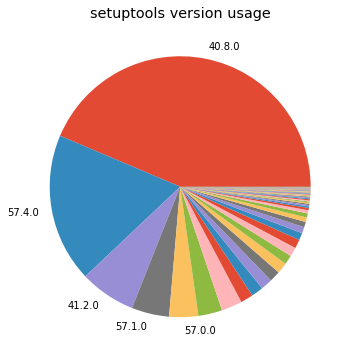

In [71]:
total = sum(v[1] for v in setuptools_versions.values)
labels = [v[0] if v[1] / total > 0.03 else '' for v in setuptools_versions.values]

plt.pie(setuptools_versions.c, labels=labels)
plt.title('setuptools version usage')

plt.savefig('setuptools-vers.png')

plt.show()

In [52]:
import csv
from glob import glob
from collections import defaultdict

In [53]:
ONE_TB = 1e12
months = ('202007', '202008', '202009', '202010', '202011', '202012', '202101', '202102', '202103', '202104', '202105', '202106', '202107', '202108', '202109')

bandwidth = {}
bandwidth_totals = defaultdict(int)
for month in months:
    bandwidth[month] = defaultdict(int)
    files = glob('/home/ben/piwheels-logs/' + month + '/*-sizes.csv')
    for file in files:
        with open(file) as f:
            r = csv.reader(f)
            for log_type, count in r:
                bandwidth[month][log_type] += int(count)
                bandwidth_totals[month] += int(count) / ONE_TB

In [54]:
for month, data in bandwidth_totals.items():
    print(month, f'{data:.2f} TB')

202007 3.92 TB
202008 6.38 TB
202009 6.27 TB
202010 6.58 TB
202011 4.43 TB
202012 3.32 TB
202101 3.79 TB
202102 5.87 TB
202103 7.07 TB
202104 5.35 TB
202105 4.82 TB
202106 4.72 TB
202107 4.02 TB
202108 4.29 TB
202109 3.91 TB


In [55]:
m1, m2, m3 = months[-3:]

bandwidth_in_period = {
    'pip downloads': bandwidth[m1]['LOGDOWNLOAD'] + bandwidth[m2]['LOGDOWNLOAD'] + bandwidth[m3]['LOGDOWNLOAD'],
    'Misc': bandwidth[m1]['OTHER'] + bandwidth[m2]['OTHER'] + bandwidth[m3]['OTHER'],
    'Searches': bandwidth[m1]['LOGSEARCH'] + bandwidth[m2]['LOGSEARCH'] + bandwidth[m3]['LOGSEARCH'],
    '': (
        bandwidth[m1]['LOGPROJECT'] + bandwidth[m2]['LOGPROJECT'] + bandwidth[m3]['LOGPROJECT'] +
        bandwidth[m1]['LOGJSON'] + bandwidth[m2]['LOGJSON'] + bandwidth[m3]['LOGJSON'] +
        bandwidth[m1]['LOGPAGE'] + bandwidth[m2]['LOGPAGE'] + bandwidth[m3]['LOGPAGE']
    ),
}

bandwidth_in_period

{'pip downloads': 9366969296154,
 'Misc': 2446768732550,
 'Searches': 387471006722,
 '': 16139500833}

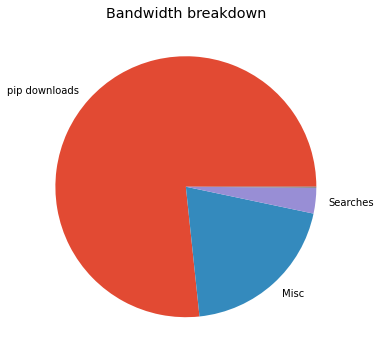

In [72]:
plt.pie(bandwidth_in_period.values(), labels=bandwidth_in_period.keys())
plt.title('Bandwidth breakdown')

plt.savefig('bandwidth.png')

plt.show()

In [57]:
for k, v in bandwidth_in_period.items():
    pc = 100 * (v / sum(bandwidth_in_period.values()))
    print(k, f'{pc:.2f}%')

pip downloads 76.67%
Misc 20.03%
Searches 3.17%
 0.13%


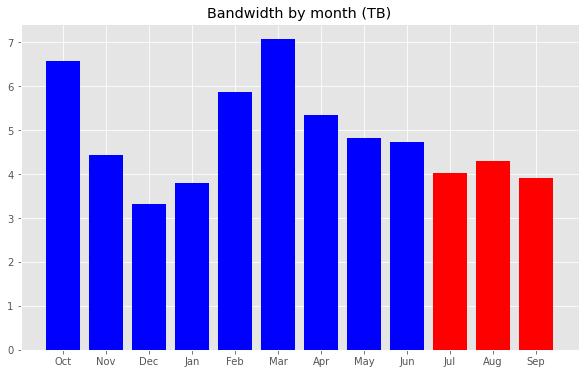

In [73]:
bandwidth_by_month = {
    'Oct': bandwidth_totals['202010'],
    'Nov': bandwidth_totals['202011'],
    'Dec': bandwidth_totals['202012'],
    'Jan': bandwidth_totals['202101'],
    'Feb': bandwidth_totals['202102'],
    'Mar': bandwidth_totals['202103'],
    'Apr': bandwidth_totals['202104'],
    'May': bandwidth_totals['202105'],
    'Jun': bandwidth_totals['202106'],
    'Jul': bandwidth_totals['202107'],
    'Aug': bandwidth_totals['202108'],
    'Sep': bandwidth_totals['202109'],
}

colors = ['blue']*9 + ['red']*3
plt.bar(range(len(bandwidth_by_month)), bandwidth_by_month.values(), color=colors)
plt.title('Bandwidth by month (TB)')
plt.xticks(range(len(bandwidth_by_month)), list(bandwidth_by_month.keys()))

plt.savefig('bandwidth-by-month.png')

plt.show()